### Begin Weighting PCnet

In [1]:
import pandas as pd
import numpy as np
import ndex2
import networkx as nx
import scipy.sparse

#### Adjacency Matrix- GIANT

In [ ]:
# read in nwnet (GIANT with HGNC) 
with open('nwnet', 'rb') as f:
    nwnet = nx.read_gpickle(f)
    
f.close()

In [3]:
# get dict of nodenames
nw_nodedict = nx.get_node_attributes(nwnet, "name")
# get list of node names
nw_nodelist = list(nw_nodedict.values())

In [4]:
# get attribute matrix for edges 
# supply node_dict for ordering
nwnet_probs = nx.attr_matrix(nwnet, edge_attr='post_prob', normalized=False, rc_order=nw_nodedict)

In [5]:
# check type
type(nwnet_probs)

numpy.matrixlib.defmatrix.matrix

In [6]:
# redefine nwnet_probs as pandas dataframe with nodenames as the column and rownames
nwnet_probs = pd.DataFrame(nwnet_probs, index=nw_nodelist,columns=nw_nodelist)

In [7]:
# check matrix
nwnet_probs.iloc[0:5,0:5]
# nwnet_probs[0:5,0:5]

,A1BG,RNA28SN5,LINC02584,NR2E3,SNORD116-2
A1BG,0.000000,0.101838,0.100589,0.103316,0.101577
RNA28SN5,0.101838,0.000000,0.000000,0.000000,0.000000
LINC02584,0.100589,0.000000,0.000000,0.000000,0.000000
NR2E3,0.103316,0.000000,0.000000,0.000000,0.000000
SNORD116-2,0.101577,0.000000,0.000000,0.000000,0.000000


In [10]:
# no longer need nwnet
del nwnet

#### Adjacency Matrix- PCNet

In [11]:
# read in nwnet (GIANT with HGNC) 
with open('pcnet', 'rb') as f:
    pcnet = nx.read_gpickle(f)
    
f.close()

In [12]:
# get new dict of nodenames
pc_nodedict = nx.get_node_attributes(pcnet, "name")
# get list of node names
pc_nodelist = list(pc_nodedict.values())
pc_nodelist[1:5]

['RNF14', 'UBE2Q2', 'TMCO1', 'UBAC1']

In [13]:
# How many of PCnet nodes are NOT in GIANT
pc_not_there = pd.DataFrame(list(set(pc_nodelist)-set(nw_nodelist)), index=None, columns=None)
len(pc_not_there) 
# reduced from 949 to 877 

877

In [14]:
# get attribute matrix for edges 
# supply node_dict for ordering
pcnet_probs = nx.to_numpy_matrix(pcnet, nodelist=pc_nodelist)

In [15]:
# check type
type(pcnet_probs)

numpy.matrixlib.defmatrix.matrix

In [16]:
# redefine nwnet_probs as pandas dataframe with nodenames as the column and rownames
pcnet_probs = pd.DataFrame(pcnet_probs, index=pc_nodelist,columns=pc_nodelist)

In [17]:
# check matrix
pcnet_probs.iloc[0:5,0:5]
# pcnet_probs[0:5,0:5]

,UBE2Q1,RNF14,UBE2Q2,TMCO1,UBAC1
UBE2Q1,0.0,1.0,1.0,1.0,1.0
RNF14,1.0,0.0,1.0,1.0,0.0
UBE2Q2,1.0,1.0,0.0,0.0,1.0
TMCO1,1.0,1.0,0.0,0.0,0.0
UBAC1,1.0,0.0,1.0,0.0,0.0


#### Find Common Edges

In [18]:
# these are the genes we are skipping by getting the unique set from nw_nodelist
dups = [n for n in nw_nodelist if nw_nodelist.count(n) >1]

In [19]:
# find nw singles
nw_nodelist_singles = list(set(nw_nodelist)-set(dups))

In [20]:
# Which of unique NWnet nodes are in PCNet 
common = list(set(np.unique(nw_nodelist_singles)).intersection(set(pc_nodelist)))
len(common)

18408

In [21]:
# this is how many we *should* have, so we are missing 14 due to ignoring GIANT's dups 
len(pc_nodelist)-877

18422

In [22]:
# Subset probability matrices to only have common edges and check shape
pcnet_probs_ss = pcnet_probs.loc[common,common]
pcnet_probs_ss.shape

(18408, 18408)

In [23]:
# convert pcnet matrices to sparse (overwrite)
pcnet_probs_ss = scipy.sparse.csr_matrix(pcnet_probs_ss.values)
pcnet_probs = scipy.sparse.csr_matrix(pcnet_probs.values)

In [24]:
# Subset probability matrices to only have common edges and check shape
nwnet_probs_ss = nwnet_probs.loc[common,common]
nwnet_probs_ss.shape

(18408, 18408)

In [25]:
# convert nwnet probs matrices to sparse (overwrite)
nwnet_probs_ss = scipy.sparse.csr_matrix(nwnet_probs_ss.values)
nwnet_probs = scipy.sparse.csr_matrix(nwnet_probs.values)

In [26]:
nwnet_probs.data.dtype

dtype('float64')

In [27]:
# find coordinates of nonzero data in inter 
# (i.e. the common edge matrix)
x, y = pcnet_probs_ss.nonzero()
x = x.tolist() # create list
y = y.tolist() # create list

In [28]:
# instead of coordinates, find corresponding index (nodenames)
x_names = [common[i] for i in x]
y_names = [common[i] for i in y]

In [59]:
# create tuple of nodenames for edges in nwnet
coordinates = list(zip(x_names,y_names))
coordinates[0]

('DCP1A', 'LSM3')

In [30]:
# get corresponding data (nwnet probabilities) for these coordinates 
dat = nwnet_probs_ss[x,y].T

# check shape
dat.shape, len(x), len(y)

((5101988, 1), 5101988, 5101988)

In [ ]:
# will any edge weights be updated to > 0.1? 
any([x > 0.1 for x in dat])

In [ ]:
# will any edge be updated to < 0.1? 
any([x < 0.1 for x in dat]) 
# there shouldnt be any- these must be the edges that are in pcnet but not giant- so get rid of these 

In [31]:
dat_list = np.array(dat).ravel().tolist()

In [83]:
# find where dat_list (the data from GIANT) is greater than or equal to 0.1
# these are the edges we will update
dat_i = np.array([int(x >= 0.1) for x in dat_list]).nonzero()[0].tolist()
dat_i[1:5], len(dat_i)

([11, 20, 21, 22], 2850532)

In [84]:
# create a dict for these edges and the corresponding weights
# this dict contains all edges in GIANT 
update_prob = dict(zip([coordinates[i] for i in dat_i], [dat_list[i] for i in dat_i]))

In [85]:
len(update_prob)

2850532

In [ ]:
# # create a dict for these edges and the corresponding weights
# # this dict contains all edges in GIANT 
# update_prob = dict(zip(coordinates, dat_list))

In [86]:
for i in update_prob.values(): 
    if not isinstance(i,float): 
        print(i)
        break

In [87]:
type(update_prob), len(pcnet_probs_ss.nonzero()[0]), len(list(update_prob.values()))

(dict, 5101988, 2850532)

In [88]:
# rename pcnet nodes so that can reference nodes by node names
nx.relabel_nodes(pcnet, pc_nodedict)

In [89]:
# check
list(pcnet.nodes())[1:5]

['RNF14', 'UBE2Q2', 'TMCO1', 'UBAC1']

In [90]:
# update weights with 0.1
nx.set_edge_attributes(pcnet, 'p', 0.1)

In [91]:
# update weights with giant
nx.set_edge_attributes(pcnet, 'p', update_prob)

In [92]:
# check distribution of edge weights
probs = nx.get_edge_attributes(pcnet, 'p').values()

In [93]:
probs = list(probs)

In [94]:
for i in probs: 
    if not isinstance(i, float):
        print(i)
        break

In [95]:
probs[0:5]

[0.119148, 0.216301, 0.196628, 0.1, 0.140354]

In [96]:
import matplotlib.pyplot as plt 

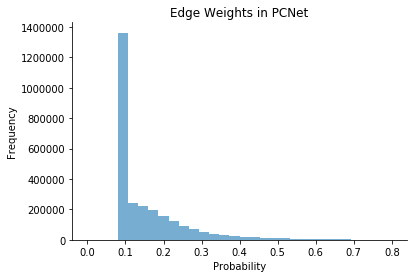

In [97]:
ax = plt.subplot()
plt.hist(probs, bins=30, range=[0,0.8], alpha=0.6, linestyle='solid')
plt.title('Edge Weights in PCNet')
plt.xlabel('Probability')
plt.ylabel('Frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

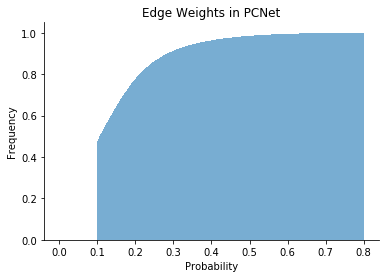

In [98]:
ax = plt.subplot()
plt.hist(probs, bins=1000, range=[0,0.8], alpha=0.6, linestyle='solid', cumulative=True, density=True)
plt.title('Edge Weights in PCNet')
plt.xlabel('Probability')
plt.ylabel('Frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [99]:
# write pcnet (weighted) 
with open('pcnet_wt', 'wb') as f:
    nx.write_gpickle(pcnet, f)
    
f.close()

### Look at network Characteristics 

In [ ]:
len(nw_nodelist)

In [ ]:
len(list(nwnet.edges()))

In [ ]:
# check distribution of edge weights
probs = nx.get_edge_attributes(nwnet, 'post_prob')

In [ ]:
# check distribution of edge weights
probs = probs.values()

In [ ]:
probs = list(probs)

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
ax = plt.subplot()
plt.hist(probs, bins=30, range=[0,0.8], alpha=0.6, linestyle='solid')
plt.title('Edge Weights in PCNet')
plt.xlabel('Probability')
plt.ylabel('Frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
ax = plt.subplot()
plt.hist(probs, bins=1000, range=[0,0.8], alpha=0.6, linestyle='solid', cumulative=True, density=True)
plt.title('Edge Weights in PCNet')
plt.xlabel('Probability')
plt.ylabel('Frequency')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
del nwnet_probs_ss
del nwnet_probs

In [ ]:
pcnet_common = pcnet.subgraph(common)

In [ ]:
len(list(pcnet_common.edges()))

In [ ]:
len(list(pcnet.edges()))

In [ ]:
# read in nwnet (GIANT with HGNC) 
with open('pcnet_wt', 'rb') as f:
    pcnet = nx.read_gpickle(f)
    
f.close()

In [ ]:
# check distribution of edge weights
probs = nx.get_edge_attributes(pcnet, 'p').values()

In [ ]:
probs = list(probs)

In [ ]:
# are any probs less than 0.1? 
any([x > 0.1 for x in probs])

In [ ]:
# read in nwnet (GIANT with HGNC) 
with open('nwnet', 'rb') as f:
    nwnet = nx.read_gpickle(f)
    
f.close()

In [ ]:
# get list of node names
nw_nodelist = list(nwnet.nodes())
# get list of node names
pc_nodelist = list(pcnet.nodes())

In [ ]:
# Get Dups and Common List 
dups = [n for n in nw_nodelist if nw_nodelist.count(n) >1]
nw_nodelist_singles = list(set(nw_nodelist)-set(dups))
common = list(set(np.unique(nw_nodelist_singles)).intersection(set(pc_nodelist)))

In [ ]:
# How many edges in PCNet versus PCNet Common
len(list(nx.edges(pcnet)))